# Seleção e pré-processamento de dados:

* **Base de dados**: ["Loan Data Set"](https://www.kaggle.com/datasets/mirzahasnine/loan-data-set?resource=download);
* **Problema a ser investigado**: Aprovação ou não aprovação de empréstimo para pessoas de acordo com seus dados;
* **Número de amostras**: 614;
* **Número de atributos**: 12;
* **Tipos de atributos**: Categóricos e numéricos;
* **Valores ausentes**: Sim.

In [1]:
#Bibliotecas:
import pandas as pd
import numpy as np

### Limpeza de dados

* Leitura da base de dados

In [5]:
def ShowInformationDataFrame(df, message=""):
    print(message+"\n")
    # Imprime as 10 primeiras linhas do arquivo
    print("PRIMEIRAS 10 LINHAS\n")
    print(df.head(10))
    print("\n")
    # Imprime informações sobre os dados
    print("INFORMAÇÕES GERAIS DOS DADOS\n")
    print(df.info())
    print("\n")
    # Imprime uma analise descritiva sobre os dados
    print("DESCRIÇÃO DOS DADOS\n")
    print(df.describe())
    print("\n")
    # Imprime a quantidade de valores faltantes por coluna
    print("VALORES FALTANTES\n")
    print(df.isnull().sum())
    print("\n") 

In [9]:
input_file = './0-Datasets/loan_train.csv'
names = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
target = 'Status'
df = pd.read_csv(input_file,        # Nome do arquivo com dados
                names = names,      # Nome das colunas 
                usecols = features, # Define as colunas que serão  utilizadas
                na_values='')       # Define que ? será considerado valores ausentes

ShowInformationDataFrame(df, "DataFrame")

DataFrame

PRIMEIRAS 10 LINHAS

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0  Not Graduate            No            604500   
1   Male      No          0      Graduate            No            584900   
2   Male     Yes          1      Graduate            No            458300   
3   Male     Yes          0      Graduate           Yes            300000   
4   Male     Yes          0  Not Graduate            No            258300   
5   Male      No          0      Graduate            No            600000   
6   Male     Yes          2      Graduate           Yes            541700   
7   Male     Yes          0  Not Graduate            No            233300   
8   Male     Yes         3+      Graduate            No            303600   
9   Male     Yes          2      Graduate            No            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History       Area Status  
0                 0.0     11500000  360.0 

* Tratamento dos valores faltantes
  * método de DELETAR os objetos que possuem valores faltantes

In [10]:
def UpdateMissingValues(df, column, method="mode", number=0):
    if method == 'number':
        # Substituindo valores ausentes por um número
        df[column].fillna(number, inplace=True)
    elif method == 'median':
        # Substituindo valores ausentes pela mediana 
        median = df[column].median()
        df[column].fillna(median, inplace=True)
    elif method == 'mean':
        # Substituindo valores ausentes pela média
        mean = df[column].mean()
        df[column].fillna(mean, inplace=True)
    elif method == 'mode':
        # Substituindo valores ausentes pela moda
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)
    elif method == 'delete':
        df.dropna(axis=0, how='any', subset=column, inplace=True)

columns_missing_value = df.columns[df.isnull().any()]
print(columns_missing_value)
method = 'delete' # number or median or mean or mode
    
for c in columns_missing_value:
    UpdateMissingValues(df, c, method)
    
ShowInformationDataFrame(df,"Dataframe UpdateMissingValues")

Index(['Gender', 'Married', 'Dependents', 'Self_Employed', 'Term',
       'Credit_History'],
      dtype='object')
Dataframe UpdateMissingValues

PRIMEIRAS 10 LINHAS

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0  Not Graduate            No            604500   
1   Male      No          0      Graduate            No            584900   
2   Male     Yes          1      Graduate            No            458300   
3   Male     Yes          0      Graduate           Yes            300000   
4   Male     Yes          0  Not Graduate            No            258300   
5   Male      No          0      Graduate            No            600000   
6   Male     Yes          2      Graduate           Yes            541700   
7   Male     Yes          0  Not Graduate            No            233300   
8   Male     Yes         3+      Graduate            No            303600   
9   Male     Yes          2      Graduate            No        

* Conversão dos atributos categóricos para numéricos

In [11]:
# Converte os atributos categóricos para numéricos
    # get all categorical columns
cat_columns = df.select_dtypes(['object']).columns

    # convert all categorical columns to numeric
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

ShowInformationDataFrame(df,"Dataframe numérico")

Dataframe numérico

PRIMEIRAS 10 LINHAS

   Gender  Married  Dependents  Education  Self_Employed  Applicant_Income  \
0       0        0           0          0              0            604500   
1       0        0           0          1              0            584900   
2       0        1           1          1              0            458300   
3       0        1           0          1              1            300000   
4       0        1           0          0              0            258300   
5       0        0           0          1              0            600000   
6       0        1           2          1              1            541700   
7       0        1           0          0              0            233300   
8       0        1           3          1              0            303600   
9       0        1           2          1              0            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History  Area  Status  
0                 0.0     

### Balanceamento de dados

In [15]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt

Base default
 1    341
0    158
Name: Status, dtype: int64
Base balanceada
 0    341
1    341
Name: Status, dtype: int64


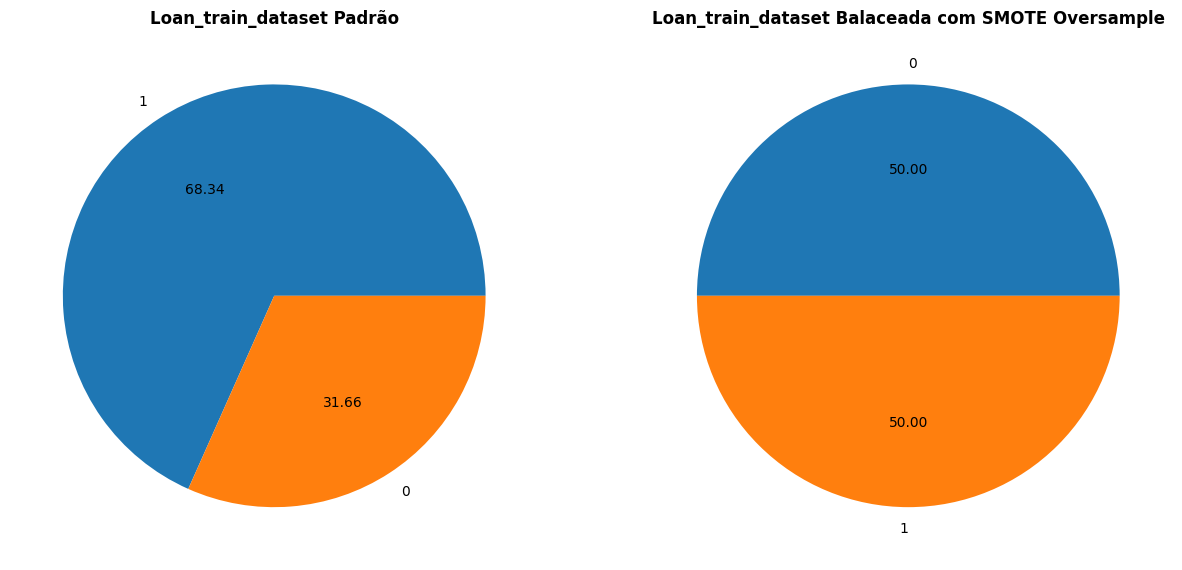

In [17]:
x = df.drop(['Status'], axis=1)
y = df['Status']

# Synthetic Minority Oversampling Technique (SMOTE)
x_os, y_os = SMOTE().fit_resample(x, y)
# Adaptive Synthetic (ADASYN) sampling method
# x_os, y_os = ADASYN().fit_resample(x, y)

print('Base default\n',y.value_counts())
print('Base balanceada\n',y_os.value_counts())

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

y.value_counts().plot.pie(ax=ax[0], autopct='%.2f')
y_os.value_counts().plot.pie(ax=ax[1], autopct='%.2f')

plt.subplots_adjust(hspace = 1)

for n in np.arange(0,2):
    ax[n].set_ylabel('')
    
ax[0].set_title('Loan_train_dataset Padrão', fontweight='bold')
ax[1].set_title('Loan_train_dataset Balaceada com SMOTE Oversample', fontweight='bold')

plt.show()

---
# Normalização e redução de dados

### Normalização de dados
* Max-Min
* Z-Score

### Redução de dados (PCA)

---
# Análise descritiva de dados
* Distribuição de frequência
* Visualização de dados (Histograma, Gráfico de setores, dispersão, etc)
* Medidas de resumo
  * Medidas de tendência central
  * Medidas de dispersão
  * Medidas de posição relativa
  * Medidas de associação

---
# Análise de grupos

### K-means
* Variar número de grupos (parâmetro k)

### GMM

### Avaliação da qualidade dos agrupamentos
* Coeficiente de forma
* Homogeneidade

---
# Classificação
* Divisão da base:
  * Holdout (Treinamento 70% e Teste 30%)
  * Cross-Validation (k=10)
* Métricas:
  * Matrix de confusão
  * Acurácia
  * F1 Score

### Árvore de Decisão (Decision Tree)

### KNN (K-Mearest Neighbors)
* Encontrar o parâmetro k com melhor resultado

### SVM (Support Vectors Machine)

### Rede Neural MLP (Multilayer Perceptron)
* Arquitetura da rede:
  * Número de neurônios
  * Camadas escondidas
  * Tipo de função de ativação

### Comparação final dos classificadores